In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import argparse
import torch
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import seaborn as sns
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path
from transformers.generation.utils import GenerationMixin
from PIL import Image
import torch.nn.functional as F
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from transformers import TextStreamer
import torchvision.transforms as transforms
import numpy as np
import sys


def load_image(image_file):
    if image_file.startswith('http://') or image_file.startswith('https://'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

if "ipykernel_launcher" in sys.argv[0]:
    sys.argv = sys.argv[:1]

parser = argparse.ArgumentParser()

parser.add_argument("--model-path", type=str, default="/code/yingqi/models/liuhaotian/llava-v1.5-7b")
parser.add_argument("--model-base", type=str, default=None)
parser.add_argument("--image-file", type=str, default=None)
parser.add_argument("--device", type=str, default="cuda")
parser.add_argument("--conv-mode", type=str, default="vicuna_v1")
parser.add_argument("--answer-with-sentence", type=bool, default=False)
parser.add_argument("--num-chunks", type=int, default=1)
parser.add_argument("--chunk-idx", type=int, default=0)
parser.add_argument("--temperature", type=float, default=0)
parser.add_argument("--top_p", type=float, default=None)
parser.add_argument("--num_beams", type=int, default=1)
parser.add_argument("--max_new_tokens", type=int, default=128)
parser.add_argument("--load-8bit", action="store_true")
parser.add_argument("--load-4bit", action="store_true")
parser.add_argument("--debug", action="store_true")
args = parser.parse_args()

disable_torch_init()

model_name = get_model_name_from_path(args.model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(args.model_path, args.model_base, model_name, args.load_8bit, args.load_4bit, device=args.device)

if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

/opt/conda/envs/llava-visipruner/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/envs/llava-visipruner/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [03:03<00:00, 91.87s/it] 


In [ ]:
if args.conv_mode is not None and conv_mode != args.conv_mode:
    print('[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}'.format(conv_mode, args.conv_mode, args.conv_mode))
else:
    args.conv_mode = conv_mode

conv = conv_templates[args.conv_mode].copy()
if "mpt" in model_name.lower():
    roles = ('user', 'assistant')
else:
    roles = conv.roles

IMAGE_PATH = "./images/514915.jpg"
inp = "Is there any scooter in the image?\nAnswer with a single word or short phrase."
image = load_image(IMAGE_PATH)
image_size = image.size
# Similar operation in model_worker.py
image_tensor = process_images([image], image_processor, model.config)
if type(image_tensor) is list:
    image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(model.device, dtype=torch.float16)

print(f"{roles[1]}: ", end="")

if image is not None:
    # first message
    if model.config.mm_use_im_start_end:
        inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    else:
        inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
    image = None

conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

with torch.inference_mode():
    output = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image_size],
        do_sample= False,
        temperature=0,
        max_new_tokens=args.max_new_tokens,
        streamer=streamer,
        output_hidden_states=True,
        output_attentions=True,
        return_dict_in_generate=True  # Return as a dictionary so you can access attentions
    )

[WARNING] the auto inferred conversation mode is llava_v1, while `--conv-mode` is vicuna_v1, using vicuna_v1
ASSISTANT: 

/opt/conda/envs/llava-visipruner/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Yes


In [26]:
vlm_attn_weights = torch.stack(output['attentions'][0]).mean(dim=2)
last_to_vision_attn = vlm_attn_weights[:, 0, -1, 35:611]
values = [layer[1] for layer in output['past_key_values']]
vision_values_states = torch.stack([layer[0] for layer in values])[:,:, 35:611, :]
l1_norm_value_states = vision_values_states.norm(p=1, dim=-1).norm(p=1, dim=1)

(0.0, 576.0)

Text(0, 0.5, 'L1 norm of V')

Text(0.5, 1.0, 'L1 Norm of Value Matrix per Patch')

(5.3644180297851564e-08, 0.00250701904296875)

(0.0, 576.0)

Text(0.5, 1.0, 'Attention Weight (Zoomed In)')

Text(0, 0.5, 'Attention Weight')

(0.0, 576.0)

Text(0.5, 1.0, 'Attention Weight')

Text(0, 0.5, 'Attention Weight')

Text(0.5, 0.01, 'Patch Index')

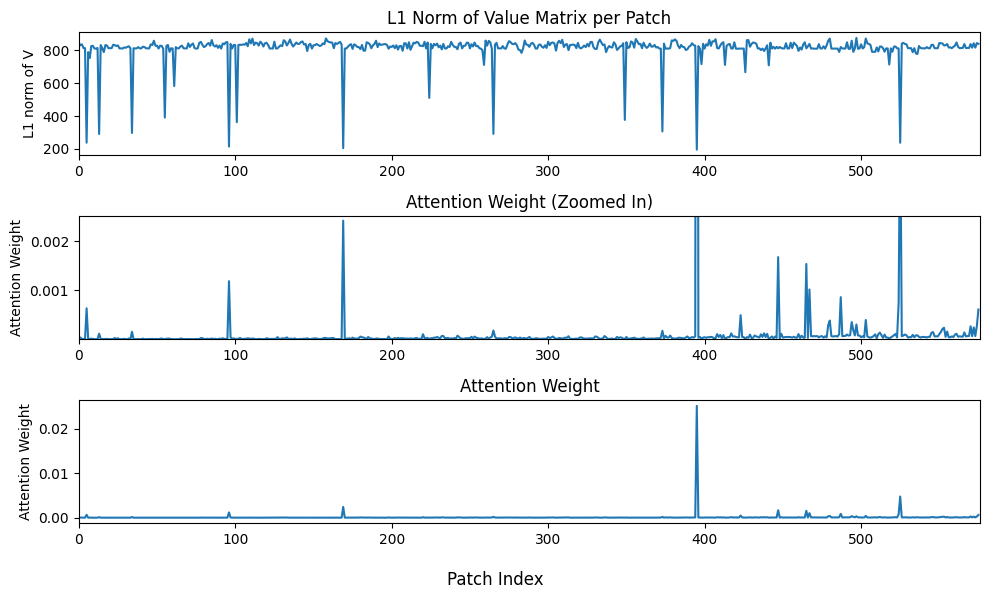

In [52]:
layer_idx = 3
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

y1 = l1_norm_value_states[layer_idx].cpu().numpy()
axes[0].plot(y1)
axes[0].set_xlim(0, len(y1))
axes[0].set_ylabel('L1 norm of V')
axes[0].set_title('L1 Norm of Value Matrix per Patch')

y2 = last_to_vision_attn[layer_idx].cpu().numpy()
axes[1].plot(y2)
axes[1].set_ylim(min(y2) * 0.9, max(y2) * 0.1)
axes[1].set_xlim(0, len(y1))
axes[1].set_title('Attention Weight (Zoomed In)')
axes[1].set_ylabel('Attention Weight')


axes[2].plot(y2)
axes[2].set_xlim(0, len(y1))
axes[2].set_title('Attention Weight')
axes[2].set_ylabel('Attention Weight')


fig.supxlabel('Patch Index')

plt.tight_layout()


plt.show()